In [75]:
!pip install --upgrade pip

!pip install wordcloud

!pip install neattext

!pip install imblearn

!pip install mglearn

!pip install scikit-plot

!pip install keras-tqdm

!pip install gensim

!pip install pydot

!pip install pyldavis==2.1.2

In [2]:
import re
import string
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
get_ipython().magic('matplotlib inline')

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation 

import neattext as nt
import neattext.functions as nfx
from wordcloud import WordCloud, STOPWORDS, tokenization

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 100)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense, SpatialDropout1D
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D, GRU, SeparableConv2D, SeparableConv1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.metrics import Accuracy, Precision, Recall, AUC
from keras.utils.vis_utils import plot_model

from keras_tqdm import TQDMNotebookCallback
from keras.layers import Dense, Activation, MaxPooling1D, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras_tqdm import TQDMCallback 

## Read in Data

In [4]:
df = pd.read_csv("../../lemm_data.csv")

pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 400)

## Define X and y variables

In [5]:
X = df['texts']
y = df[['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']]

### Assign Weights

In order to combat class imbalance in my data set, I am assigning weights for each label.

In [6]:
cate = pd.DataFrame(y.sum()).reset_index().rename(columns = {'index':'genres1',0:'count'})
cate.head()

,genres1,count
0,Action,296
1,Adventure,179
2,Comedy,368
3,Crime,215
4,Drama,615


In [7]:
labels1 = cate.genres1.values

In [8]:
cate['class_weight'] = len(cate) / cate['count']
class_weight = {}
for index, label in enumerate(labels1):
    class_weight[index] = cate[cate['genres1'] == label]['class_weight'].values[0]
    
cate.head()

,genres1,count,class_weight
0,Action,296,0.037162
1,Adventure,179,0.061453
2,Comedy,368,0.029891
3,Crime,215,0.051163
4,Drama,615,0.017886


In [10]:
# cate.sort_values('count')

## Train-Test-Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
#Preview the shape of training and test set
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (855,)
y_train Shape: (855, 11)
X_test Shape: (286,)
y_test Shape: (286, 11)


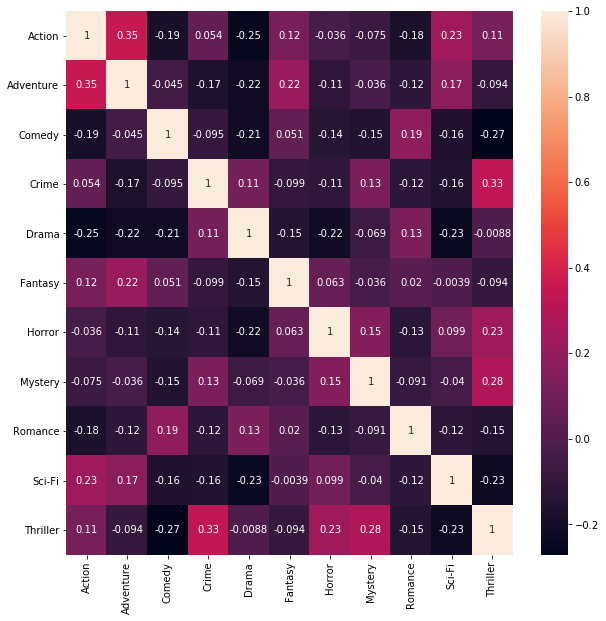

In [13]:
#Correlation matrix
corr=y_train.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

plt.show()

Although there is overlap between genre labels, it appears as though there is not much positive correlation between each of the individual labels. The most highly correlated genres seem to be Action and Adventure followed by Crime and Thriller. This makes sense given the content normally displayed in these genres.

## Latent Dirichlet Allocation (LDA)

Here, I am previewing if there are any major topics that can be gleened from the dataset.

In [14]:
vect = CountVectorizer(max_features=20000, ngram_range=(1, 4), min_df = 10, max_df = .95, stop_words='english')
X_train_vect = vect.fit_transform(X_train)
X_vect_test = vect.transform(X_test)

In [24]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=20, max_iter=25, learning_method = 'online', n_jobs=-1) 
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once 

document_topics = lda.fit_transform(X_train_vect)

In [17]:
# For each topic (a row in the components_), sort the features (ascending) # Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

In [20]:
import mglearn
# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(12), feature_names=feature_names,
                                sorting=sorting, topics_per_chunk=6, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
jake          fuck          charlie       jack          alex          
jacob         gun           phil          frank         peter         
danny         cop           sidney        woman         logan         
chris         street        jimmy         girl          ali           
ryan          shit          sara          boy           ben           
caesar        kill          rev           mother        matt          
james         ray           tommy         mr            carrie        
karen         money         drew          george        brian         
thor          drive         patrick       mary          elli          
ron           shot          steven        glance        jennifer      


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
john

In [21]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method = 'online', n_jobs=-1)
document_topics100 = lda100.fit_transform(X_train_vect)

In [22]:
#display sample of topics
topics = np.array([7, 16, 24, 25, 28, 36, 37, 45, 51, 53, 54, 63, 89, 97])

sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]

feature_names = np.array(vect.get_feature_names())

mglearn.tools.print_topics(topics=topics, feature_names=feature_names, sorting=sorting, topics_per_chunk=7, n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      
--------      --------      --------      --------      --------      --------      --------      
toby          peter         ship          danny         bond          fred          jerry         
memphis       steve         max           mike          derek         rick          ya            
eddie         mary          control       abby          eli           maggie        yah           
carrie        lucy          space         jackie        ace           hog           marge         
alex          clay          air           kyle          cameron       guy           freddie       
street        susan         president     terry         dan           missy         norm          
jack          wyatt         luke          curtis        dr            hall          meredith      
ryan          emily         screen        hannah        laurie        leigh         snow          
shit      

In [25]:
#Visualize LDA topics
vis = pyLDAvis.sklearn.prepare(lda, X_train_vect, vect)
pyLDAvis.display(vis)

There is a lot of overlap in these topics which is typically not what we want to see. From view the topics above it is clear that many of the topics include the names of characters which is likely the reason for the overlap.

## Embedding

In [ ]:
#Implementing glove to create an embedding layer

In [26]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

In [27]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [28]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [29]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('../../glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## t-SNE

TSNE allows me to visualize my vector relationships on a 2D scale.

In [30]:
from sklearn.manifold import TSNE

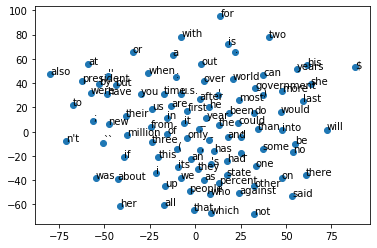

In [31]:
tsne = TSNE(n_components=2, random_state=0)
words =  list(embeddings_dictionary.keys())
vectors = [embeddings_dictionary[word] for word in words]
Yt = tsne.fit_transform(vectors[150:250])
plt.scatter(Yt[:, 0], Yt[:, 1])

for label, x, y in zip(words, Yt[:, 0], Yt[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

This displays the relationship between each of these words. In this particular snapshot there are very closely related like "world" and "government" while "his"(upper right) and "her"(lower left) are have a further euclidean distance.

## Model A - Simple

In [32]:
modela = Sequential()

modela.add(Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False))

modela.add(LSTM(128))

modela.add(Dense(22, activation='relu'))
modela.add(Dropout(0.2))
modela.add(Dense(11, activation='sigmoid'))

modela.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall(), AUC(), 'acc'])

modela.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         26949000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 22)                2838      
_________________________________________________________________
dropout_1 (Dropout)          (None, 22)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                253       
Total params: 27,171,739
Trainable params: 222,739
Non-trainable params: 26,949,000
_________________________________________________________________


In [33]:
callbacks1 = [
    ReduceLROnPlateau(), 
    TQDMNotebookCallback(leave_inner = True, leave_outer = True),
    EarlyStopping(monitor='val_loss', patience=10), 
    ModelCheckpoint(filepath='../../modela-conv1d1.h5', monitor='val_loss', save_best_only=True)
]


In [34]:
historya = modela.fit(X_train, y_train, class_weight=class_weight, batch_size=128, epochs=50, verbose=0, validation_split=0.2,callbacks=callbacks1)

In [37]:
score = modela.evaluate(X_test, y_test, verbose=1)
print(score)
print("Test Loss:", score[0])
print("Test Accuracy:", score[-1])

286/286 [==============================] - 1s 2ms/step
[0.49943567197639627, 0.0, 0.0, 0.6838269829750061, 0.7733629941940308]
Test Loss: 0.49943567197639627
Test Accuracy: 0.7733629941940308


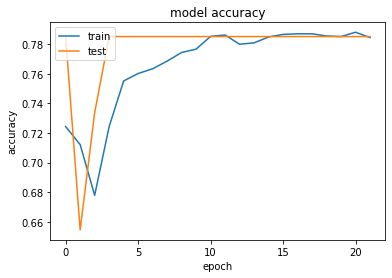

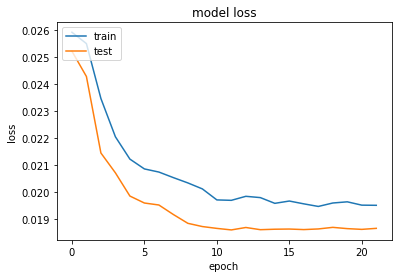

In [38]:
plt.plot(historya.history['acc'])
plt.plot(historya.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(historya.history['loss'])
plt.plot(historya.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Model B - Added Layers

In [39]:
modelb = Sequential()

modelb.add(Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False))

modelb.add(LSTM(128, return_sequences=True))
modelb.add(Dropout(0.2))

modelb.add(LSTM(128, return_sequences=True))
modelb.add(Dropout(0.2))

modelb.add(LSTM(128))
modelb.add(Dropout(0.2))

modelb.add(Dense(22, activation='relu'))
modelb.add(Dropout(0.2))
modelb.add(Dense(11, activation='sigmoid'))


modelb.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall(), AUC(), 'acc'])

modelb.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         26949000  
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         219648    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [81]:
!pip install pydot
!pip install pydotplus

!pip install graphviz

     |████████████████████████████████| 278 kB 6.4 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=392cadbca05c10e9b87d2ff4271c999c2deb9ce60d9cb5808d37c84d15debb8a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/1f/5c/ba/f931f74fcac8f48b18ae597279203b1c1f92fc76249c2b6f66
Successfully built pydotplus


In [85]:
import keras
import pydot
import pydotplus
from pydotplus import graphviz
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

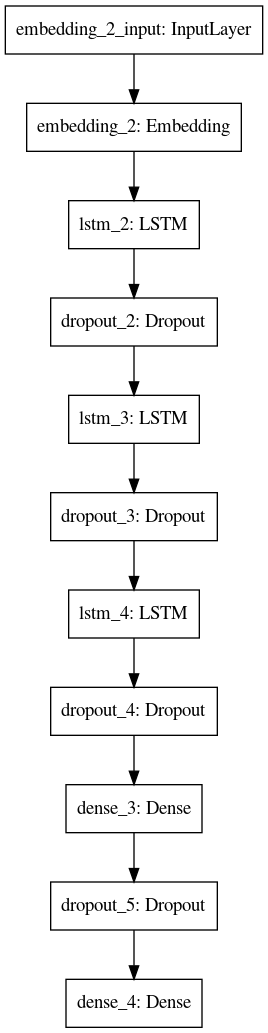

In [87]:
plot_model(modelb, to_file='../../modelb_plot.png', show_shapes=False, show_layer_names=True)

In [40]:
callbacks2 = [
    ReduceLROnPlateau(), 
    TQDMNotebookCallback(leave_inner = True, leave_outer = True),
    EarlyStopping(monitor='val_loss', patience=10), 
    ModelCheckpoint(filepath='../../modelb-conv1d1.h5', monitor='val_loss', save_best_only=True)
]

historyb = modelb.fit(X_train, y_train, class_weight=class_weight, batch_size=128, epochs=50, verbose=0, validation_split=0.2, callbacks=callbacks2)

In [41]:
score = modelb.evaluate(X_test, y_test, verbose=1)
print(score)
print("Test Loss:", score[0])
print("Test Accuracy:", score[-1])

286/286 [==============================] - 2s 5ms/step
[0.49898679564882825, 0.0, 0.0, 0.6854757070541382, 0.7733629941940308]
Test Loss: 0.49898679564882825
Test Accuracy: 0.7733629941940308


In [ ]:
y_preds = modelb.predict(X_test[:5])

print(y_preds > 0.5)

print(y_test[:5])

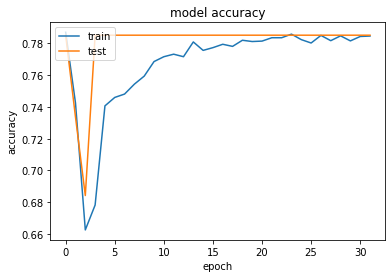

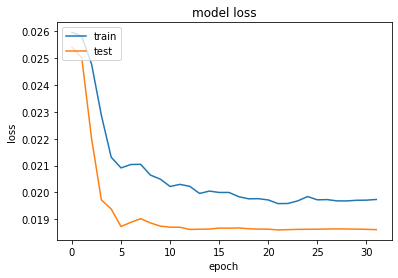

In [43]:
plt.plot(historyb.history['acc'])
plt.plot(historyb.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(historyb.history['loss'])
plt.plot(historyb.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Model C

In [44]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [45]:
modelc = Sequential()

modelc.add(Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False))
modelc.add(LSTM(25, return_sequences=True))
modelc.add(GlobalMaxPool1D())
modelc.add(Dropout(0.5))
modelc.add(Dense(50, activation='relu'))
modelc.add(Dropout(0.5))
modelc.add(Dense(11, activation='sigmoid'))

modelc.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         26949000  
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 25)          32600     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 11)               

In [46]:
modelc.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[Precision(), Recall(), AUC(), 'acc'])

In [47]:
callbacks3 = [
    ReduceLROnPlateau(), 
    TQDMNotebookCallback(leave_inner = True, leave_outer = True),
    EarlyStopping(monitor='val_loss', patience=10), 
    ModelCheckpoint(filepath='../../modelc-conv1d1.h5', monitor='val_loss', save_best_only=True)
]

historyc = modelc.fit(X_train, y_train, class_weight=class_weight, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks3)

Train on 684 samples, validate on 171 samples


Epoch 1/50


684/684 [==============================] - 7s 11ms/step - loss: 0.0259 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - auc_3: 0.5054 - acc: 0.7864 - val_loss: 0.0252 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.5019 - val_acc: 0.7852

Epoch 2/50


684/684 [==============================] - 5s 7ms/step - loss: 0.0253 - precision_3: 0.3348 - recall_3: 0.0936 - auc_3: 0.5689 - acc: 0.7674 - val_loss: 0.0237 - val_precision_3: 0.2281 - val_recall_3: 0.0965 - val_auc_3: 0.5562 - val_acc: 0.7358

Epoch 3/50


684/684 [==============================] - 5s 7ms/step - loss: 0.0221 - precision_3: 0.3442 - recall_3: 0.2035 - auc_3: 0.5730 - acc: 0.7479 - val_loss: 0.0193 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6129 - val_acc: 0.7852

Epoch 4/50


684/684 [==============================] - 5s 7ms/step - loss: 0.0208 - precision_3: 0.3919 - recall_3: 0.1392 - auc_3: 0.5893 - acc: 0.7707 - val_loss: 0.0189 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6691 - val_acc: 0.7852

Epoch 5/50


684/684 [==============================] - 4s 7ms/step - loss: 0.0203 - precision_3: 0.3860 - recall_3: 0.0930 - auc_3: 0.6062 - acc: 0.7754 - val_loss: 0.0189 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6694 - val_acc: 0.7852

Epoch 6/50


684/684 [==============================] - 4s 7ms/step - loss: 0.0202 - precision_3: 0.4167 - recall_3: 0.0749 - auc_3: 0.6034 - acc: 0.7807 - val_loss: 0.0188 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6694 - val_acc: 0.7852

Epoch 7/50


684/684 [==============================] - 5s 7ms/step - loss: 0.0203 - precision_3: 0.3430 - recall_3: 0.0518 - auc_3: 0.5974 - acc: 0.7770 - val_loss: 0.0189 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6629 - val_acc: 0.7852

Epoch 8/50


684/684 [==============================] - 4s 7ms/step - loss: 0.0200 - precision_3: 0.3980 - recall_3: 0.0487 - auc_3: 0.6068 - acc: 0.7818 - val_loss: 0.0187 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6694 - val_acc: 0.7852

Epoch 9/50


684/684 [==============================] - 4s 7ms/step - loss: 0.0199 - precision_3: 0.4201 - recall_3: 0.0443 - auc_3: 0.6147 - acc: 0.7835 - val_loss: 0.0187 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6674 - val_acc: 0.7852

Epoch 10/50


684/684 [==============================] - 5s 7ms/step - loss: 0.0200 - precision_3: 0.4610 - recall_3: 0.0406 - auc_3: 0.6147 - acc: 0.7856 - val_loss: 0.0187 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6735 - val_acc: 0.7852

Epoch 11/50


684/684 [==============================] - 5s 7ms/step - loss: 0.0198 - precision_3: 0.3741 - recall_3: 0.0325 - auc_3: 0.6171 - acc: 0.7824 - val_loss: 0.0187 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6718 - val_acc: 0.7852

Epoch 12/50


684/684 [==============================] - 5s 7ms/step - loss: 0.0197 - precision_3: 0.5049 - recall_3: 0.0325 - auc_3: 0.6189 - acc: 0.7872 - val_loss: 0.0187 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6762 - val_acc: 0.7852

Epoch 13/50


684/684 [==============================] - 4s 7ms/step - loss: 0.0197 - precision_3: 0.4045 - recall_3: 0.0225 - auc_3: 0.6285 - acc: 0.7848 - val_loss: 0.0187 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6728 - val_acc: 0.7852

Epoch 14/50


684/684 [==============================] - 5s 7ms/step - loss: 0.0197 - precision_3: 0.5341 - recall_3: 0.0293 - auc_3: 0.6229 - acc: 0.7879 - val_loss: 0.0187 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6711 - val_acc: 0.7852

Epoch 15/50


684/684 [==============================] - 4s 7ms/step - loss: 0.0195 - precision_3: 0.4265 - recall_3: 0.0181 - auc_3: 0.6341 - acc: 0.7858 - val_loss: 0.0186 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6744 - val_acc: 0.7852

Epoch 16/50


684/684 [==============================] - 4s 7ms/step - loss: 0.0194 - precision_3: 0.5556 - recall_3: 0.0218 - auc_3: 0.6384 - acc: 0.7880 - val_loss: 0.0187 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6732 - val_acc: 0.7852

Epoch 17/50


684/684 [==============================] - 5s 7ms/step - loss: 0.0196 - precision_3: 0.4630 - recall_3: 0.0156 - auc_3: 0.6351 - acc: 0.7865 - val_loss: 0.0186 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6804 - val_acc: 0.7852

Epoch 18/50


684/684 [==============================] - 5s 7ms/step - loss: 0.0196 - precision_3: 0.5000 - recall_3: 0.0144 - auc_3: 0.6266 - acc: 0.7871 - val_loss: 0.0186 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6760 - val_acc: 0.7852

Epoch 19/50


684/684 [==============================] - 4s 7ms/step - loss: 0.0195 - precision_3: 0.5952 - recall_3: 0.0156 - auc_3: 0.6346 - acc: 0.7881 - val_loss: 0.0186 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6785 - val_acc: 0.7852

Epoch 20/50


684/684 [==============================] - 5s 8ms/step - loss: 0.0194 - precision_3: 0.6957 - recall_3: 0.0100 - auc_3: 0.6345 - acc: 0.7883 - val_loss: 0.0186 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6741 - val_acc: 0.7852

Epoch 21/50


684/684 [==============================] - 13s 19ms/step - loss: 0.0195 - precision_3: 0.4688 - recall_3: 0.0094 - auc_3: 0.6336 - acc: 0.7868 - val_loss: 0.0187 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6805 - val_acc: 0.7852

Epoch 22/50


684/684 [==============================] - 34s 50ms/step - loss: 0.0194 - precision_3: 0.3939 - recall_3: 0.0081 - auc_3: 0.6402 - acc: 0.7862 - val_loss: 0.0186 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6823 - val_acc: 0.7852

Epoch 23/50


684/684 [==============================] - 26s 38ms/step - loss: 0.0193 - precision_3: 0.2857 - recall_3: 0.0037 - auc_3: 0.6447 - acc: 0.7859 - val_loss: 0.0186 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6780 - val_acc: 0.7852

Epoch 24/50


684/684 [==============================] - 25s 37ms/step - loss: 0.0194 - precision_3: 0.4000 - recall_3: 0.0037 - auc_3: 0.6367 - acc: 0.7867 - val_loss: 0.0186 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6754 - val_acc: 0.7852

Epoch 25/50


684/684 [==============================] - 25s 37ms/step - loss: 0.0194 - precision_3: 0.4286 - recall_3: 0.0037 - auc_3: 0.6432 - acc: 0.7868 - val_loss: 0.0186 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6775 - val_acc: 0.7852

Epoch 26/50


684/684 [==============================] - 26s 38ms/step - loss: 0.0194 - precision_3: 0.5333 - recall_3: 0.0050 - auc_3: 0.6345 - acc: 0.7872 - val_loss: 0.0186 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6775 - val_acc: 0.7852

Epoch 27/50


684/684 [==============================] - 25s 37ms/step - loss: 0.0194 - precision_3: 0.5000 - recall_3: 0.0062 - auc_3: 0.6439 - acc: 0.7871 - val_loss: 0.0186 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6797 - val_acc: 0.7852

Epoch 28/50


684/684 [==============================] - 14s 20ms/step - loss: 0.0193 - precision_3: 0.4545 - recall_3: 0.0031 - auc_3: 0.6455 - acc: 0.7869 - val_loss: 0.0186 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.6780 - val_acc: 0.7852




In [48]:
score = modelc.evaluate(X_test, y_test, verbose=1)
print(score)
print("Test Loss:", score[0])
print("Test Accuracy:", score[-1])

286/286 [==============================] - 0s 1ms/step
[0.4999984365243178, 0.0, 0.0, 0.6800349950790405, 0.7733629941940308]
Test Loss: 0.4999984365243178
Test Accuracy: 0.7733629941940308


In [49]:
y_pred = modelc.predict(X_test)

y_preds = modelc.predict(X_test[:5])

y_preds > 0.5

In [52]:
print(y_test[:5])

      Action  Adventure  Comedy  Crime  Drama  Fantasy  Horror  Mystery  \
1071       1          0       0      0      1        0       0        0   
907        0          0       1      0      0        1       0        0   
290        1          0       0      1      1        0       0        0   
844        0          0       0      0      1        0       0        0   
333        1          0       0      1      1        0       0        0   

      Romance  Sci-Fi  Thriller  
1071        0       0         0  
907         0       0         0  
290         0       0         1  
844         0       0         0  
333         0       0         1  


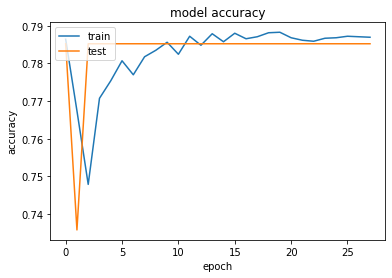

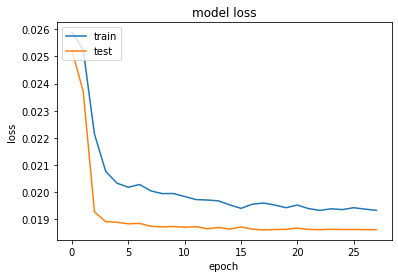

In [63]:
plt.plot(historyc.history['acc'])
plt.plot(historyc.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(historyc.history['loss'])
plt.plot(historyc.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Model D - GRU layers


In [54]:
from keras_tqdm import TQDMNotebookCallback

from keras.models import Sequential
from keras.layers import Dense, Activation, MaxPooling1D, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D, GRU, SeparableConv2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras_tqdm import TQDMCallback 

# tqdm_callback = tfa.callbacks.TQDMProgressBar()

filter_length = 64
num_classes = 11
modeld = Sequential()
modeld.add(Embedding(vocab_size, 128, input_length=maxlen))
modeld.add(GRU(128, return_sequences=True))
modeld.add(Dropout(0.1))
modeld.add(GRU(128, return_sequences=True))
# model.add(SeparableConv2D(filter_length, 5, padding='valid', activation='relu', strides=1))
modeld.add(GlobalMaxPool1D())
modeld.add(Dropout(0.5))
modeld.add(Dense(50, activation='relu'))
modeld.add(Dropout(0.5))
modeld.add(Dense(11, activation='sigmoid'))

modeld.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall(), AUC(), 'acc'])
modeld.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 128)          11498240  
_________________________________________________________________
gru_1 (GRU)                  (None, 200, 128)          98688     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 200, 128)          98688     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)               

In [55]:
callbacks4 = [
    ReduceLROnPlateau(), 
    TQDMNotebookCallback(leave_inner = True, leave_outer = True),
    EarlyStopping(monitor='val_loss', patience=10), 
    ModelCheckpoint(filepath='../../modeld-conv1d1.h5', monitor='val_loss', save_best_only=True)
]

historyd = modeld.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=40,
                    batch_size=10,
                    validation_split=0.2,
                    callbacks=callbacks4,
                   verbose=0)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [56]:
scored = modeld.evaluate(X_test, y_test, verbose=1)
print(scored)
print("Test Loss:", scored[0])
print("Test Accuracy:", scored[-1])

286/286 [==============================] - 1s 5ms/step
[0.5682461186722442, 0.4699331820011139, 0.29593268036842346, 0.689056396484375, 0.7647806406021118]
Test Loss: 0.5682461186722442
Test Accuracy: 0.7647806406021118


In [57]:
y_pred = modeld.predict(X_test)

In [58]:
y_preds = modeld.predict(X_test[:5])

In [59]:
(y_preds > 0.5)

array([[ True, False, False, False, False, False, False, False, False,
        False, False],
       [False, False,  True, False,  True, False, False, False,  True,
        False, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False],
       [False, False, False, False,  True, False, False, False, False,
        False,  True],
       [False, False, False, False, False, False, False, False, False,
        False,  True]])

In [60]:
print(y_test[:5])

      Action  Adventure  Comedy  Crime  Drama  Fantasy  Horror  Mystery  \
1071       1          0       0      0      1        0       0        0   
907        0          0       1      0      0        1       0        0   
290        1          0       0      1      1        0       0        0   
844        0          0       0      0      1        0       0        0   
333        1          0       0      1      1        0       0        0   

      Romance  Sci-Fi  Thriller  
1071        0       0         0  
907         0       0         0  
290         0       0         1  
844         0       0         0  
333         0       0         1  


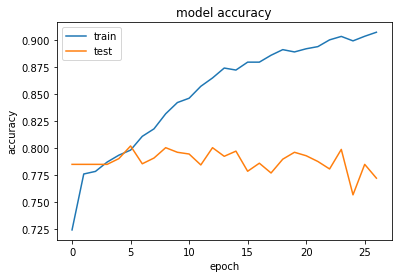

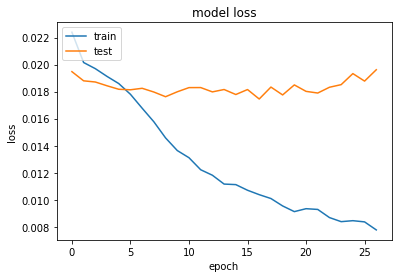

In [61]:
plt.plot(historyd.history['acc'])
plt.plot(historyd.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(historyd.history['loss'])
plt.plot(historyd.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

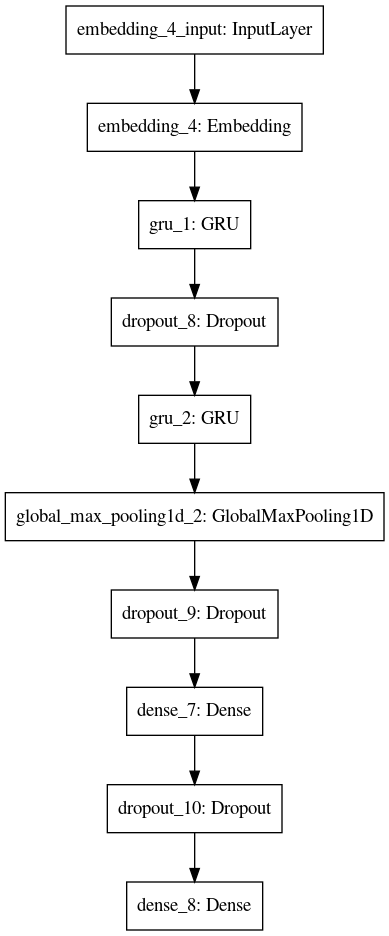

In [88]:
plot_model(modeld, to_file='../../modeld_plot.png', show_shapes=False, show_layer_names=True)

In [62]:
def plot_roc(model,y_bin,X):
    fpr = {}
    tpr = {}
    for i, cl in enumerate(model.classes_):
        fpr[cl], tpr[cl], _ = metrics.roc_curve(y_bin[:,i],model.predict_proba(X)[:,i])
    auc_scores = [round(metrics.roc_auc_score(y_bin[:,i],model.predict_proba(X)[:,i]),2) for i in range(len(model.classes_))]
    for i, key in enumerate(fpr.keys()):
        plt.plot(fpr[key],tpr[key],lw=2,label='class {}, ROC_AUC {}'.format(key,auc_scores[i]))
    plt.plot([0,1],[0,1],ls='--',lw=2)
    plt.ylim([0,1.05])
    plt.legend(loc='lower right')
    plt.title('ROC Curve',fontsize=20)
    plt.xlabel('FPR',fontsize=18)
    plt.ylabel('TPR',fontsize=18)
    
    plt.show()

## Model E - Conv

In [64]:
modele = Sequential()


modele.add(Embedding(vocab_size, 32, input_length=maxlen, trainable = False))

modele.add(SeparableConv1D(128,3,activation='relu'))
modele.add(MaxPooling1D(3))

modele.add(SeparableConv1D(128,3,activation='relu'))
modele.add(MaxPooling1D(3))

modele.add(SeparableConv1D(128,3,activation='relu'))
modele.add(GlobalMaxPooling1D())

modele.add(Dense(11,activation='sigmoid'))

modele.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=[Precision(), Recall(), AUC(), 'acc'])


modele.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 32)           2874560   
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 198, 128)          4320      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 66, 128)           0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 64, 128)           16896     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
separable_conv1d_3 (Separabl (None, 19, 128)           16896     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)              

In [66]:
callbacks5 = [
    ReduceLROnPlateau(), 
    TQDMNotebookCallback(leave_inner = True, leave_outer = True),
    EarlyStopping(monitor='val_loss', patience=10), 
    ModelCheckpoint(filepath='../../modele-conv1d1.h5', monitor='val_loss', save_best_only=True)
]

historye = modele.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=40,
                    batch_size=10,
                    validation_split=0.2,
                    callbacks=callbacks5,
                   verbose=0)

In [67]:
score = modele.evaluate(X_test, y_test, verbose=1)
print(score)
print("Test Loss:", score[0])
print("Test Accuracy:", score[-1])

286/286 [==============================] - 0s 373us/step
[0.498530600246016, 0.0, 0.0, 0.6802641749382019, 0.7733629941940308]
Test Loss: 0.498530600246016
Test Accuracy: 0.7733629941940308


In [68]:
y_pred = modele.predict(X_test)

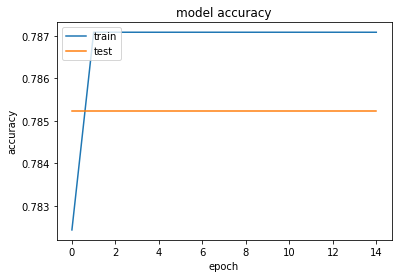

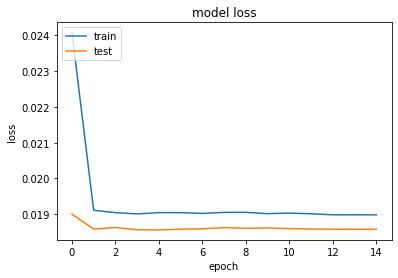

In [69]:
plt.plot(historye.history['acc'])
plt.plot(historye.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(historye.history['loss'])
plt.plot(historye.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()